
# Multiclass Supervised SVM

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import spacy
import matplotlib

In [2]:
np.random.seed(123)

- Read the data, check the distribution of sentiment scores and split the dataset in train and test

In [3]:
# df = pd.read_json('Data.json')
data = pd.read_json('Data_rescored.json')
df = data.loc[~pd.isna(data.SENTIMENT)]
df.count()

ARTICLE      343
BODY         343
DATE         343
HEADLINE     343
SENTIMENT    343
dtype: int64

In [4]:
df.loc[df.SENTIMENT==-0.5,'SENTIMENT']=-1
df.loc[df.SENTIMENT==0.5,'SENTIMENT']=1

C:\Users\petro\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# Run this chunck instead of the previous one in order to have 5 classes 

# df.loc[df.SENTIMENT==-1,'SENTIMENT']=-2
# df.loc[df.SENTIMENT==1,'SENTIMENT']=2
# df.loc[df.SENTIMENT==-0.5,'SENTIMENT']=-1
# df.loc[df.SENTIMENT==0.5,'SENTIMENT']=1

In [6]:
df.SENTIMENT.plot.hist()

In [7]:
df.groupby('SENTIMENT').count()

,ARTICLE,BODY,DATE,HEADLINE
SENTIMENT,,,,
-1.0,52,52,52,52
0.0,246,246,246,246
1.0,45,45,45,45


In [8]:
round(df.groupby('SENTIMENT').count()/df.shape[0], 3)

,ARTICLE,BODY,DATE,HEADLINE
SENTIMENT,,,,
-1.0,0.152,0.152,0.152,0.152
0.0,0.717,0.717,0.717,0.717
1.0,0.131,0.131,0.131,0.131


## Train - Test split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df, test_size=0.203, stratify= df.SENTIMENT, random_state=12345)

In [11]:
Y_train = train.SENTIMENT
Y_test = test.SENTIMENT

In [12]:
Y_train.count()

273

In [13]:
Y_test.count()

70

## Scoring Metrics

In [14]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer

In [15]:
def scores(Y_test, yhat ):
    acc = round(accuracy_score(Y_test, yhat) , 4)
    f = round(f1_score(Y_test, yhat, pos_label=1, average="macro") , 4)
    rec = round(recall_score(Y_test, yhat, pos_label=1, average="macro") , 4)
    prec = round(precision_score(Y_test, yhat, pos_label=1, average="macro") , 4)
    acc2 = round(balanced_accuracy_score(Y_test, yhat) , 4)
    scoring_temp = np.array([[acc, f, rec, prec,acc2]])
    cols = ['Accuracy', 'F-Score', 'Recall', 'Precision', 'Balanced Accuracy']
    scoring= pd.DataFrame(scoring_temp, columns=cols)
    return scoring

## BoW Approach

- Bag-of-Word approaches create sparse matrices with tokens (words) as columns
- Two different weighting procedures: CountVectorizer and TF-IDF

### CountVectorizer

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from preprocessing import PREPROCESSING

In [18]:
count_vect = CountVectorizer()
svm_classifier = svm.SVC(class_weight='balanced')

pipe = Pipeline(steps=[('vectorizer', count_vect), ('svm', svm_classifier)])

#### Linear SVM

- Optimization using stratified 5-fold cross validation

 The class distribution is not homogeneous and we are more interested in the negative and positive labels.
 
 Therefore the refrence metric is the average between F1 Scores belonging to the negative and positive classes respectively

In [20]:
param_grid =   { 'vectorizer__tokenizer':[PREPROCESSING.process, PREPROCESSING.process_lemmatizer, PREPROCESSING.process_stop,
                                          PREPROCESSING.process_lemmatizer_stop],
               'vectorizer__max_features': [500, 1000, 2000, 5000],
               'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
               'svm__kernel': ['linear'],
               'svm__C': [0.01, 0.1, 1, 10, 100]}                
    

#search_lin = GridSearchCV(pipe, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1)
search_lin = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1, n_iter=50)
fit_lin = search_lin.fit(train.ARTICLE, Y_train)
yhat_lin_cv = fit_lin.predict(test.ARTICLE)

- Results and Confusion Matrix

In [21]:
CV_cv_lin = pd.DataFrame(fit_lin.cv_results_)
#CV_cv_lin.to_latex()

In [22]:
print(fit_lin.best_params_)
print(fit_lin.best_score_) 

{'vectorizer__tokenizer': <function PREPROCESSING.process_lemmatizer at 0x00000263A3664378>, 'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': 1000, 'svm__kernel': 'linear', 'svm__C': 0.01}
0.6099755799755799


In [129]:
pd.crosstab(Y_test, yhat_lin_cv, rownames=['True'], colnames=['Predicted'], margins=True)

True,-1.0,0.0,1.0,All
Predicted,,,,
-1.0,6,3,2,11
0.0,5,45,4,54
1.0,0,2,3,5
All,11,50,9,70


In [142]:
print(classification_report(Y_test, yhat_lin_cv, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_lin_cv),3))

              precision    recall  f1-score   support

        -1.0      0.545     0.545     0.545        11
         0.0      0.833     0.900     0.865        50
         1.0      0.600     0.333     0.429         9

    accuracy                          0.771        70
   macro avg      0.660     0.593     0.613        70
weighted avg      0.758     0.771     0.759        70

balanced accuracy 0.593


#### RBF SVM

In [28]:
param_grid = { 'vectorizer__tokenizer':[PREPROCESSING.process, PREPROCESSING.process_lemmatizer, PREPROCESSING.process_stop,
                                        PREPROCESSING.process_lemmatizer_stop],
               'vectorizer__max_features': [100, 300, 500, 1000, 2000],
               'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
               'svm__kernel': ['rbf'],
               'svm__C': [ 0.01, 0.1, 1, 10, 100],
               'svm__gamma': [2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**2, 2**3, 2**4] } 

#search_rbf = GridSearchCV(pipe, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1)
search_rbf = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1, n_iter=50)
fit_rbf = search_rbf.fit(train.ARTICLE, Y_train)
yhat_rbf_cv = fit_rbf.predict(test.ARTICLE)

In [29]:
CV_cv_rbf = pd.DataFrame(fit_rbf.cv_results_)
print(fit_rbf.best_params_)
print(fit_rbf.best_score_) 

{'vectorizer__tokenizer': <function PREPROCESSING.process_lemmatizer at 0x00000263A3664378>, 'vectorizer__ngram_range': (1, 3), 'vectorizer__max_features': 500, 'svm__kernel': 'rbf', 'svm__gamma': 0.0625, 'svm__C': 1}
0.3888888888888889


In [131]:
pd.crosstab(Y_test, yhat_rbf_cv, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,All
True,,,
-1.0,1,10,11
0.0,0,50,50
1.0,0,9,9
All,1,69,70


In [147]:
print(classification_report(Y_test, yhat_rbf_cv, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_rbf_cv),3))

              precision    recall  f1-score   support

        -1.0      1.000     0.091     0.167        11
         0.0      0.725     1.000     0.840        50
         1.0      0.000     0.000     0.000         9

    accuracy                          0.729        70
   macro avg      0.575     0.364     0.336        70
weighted avg      0.675     0.729     0.626        70

balanced accuracy 0.364


In [34]:
cv_lin = scores(Y_test, yhat_lin_cv)
cv_rbf = scores(Y_test, yhat_rbf_cv)

C:\Users\petro\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vect = TfidfVectorizer()
svm_classifier = svm.SVC(class_weight='balanced')

pipe = Pipeline(steps=[('vectorizer', tfidf_vect), ('svm', svm_classifier)])

#### Linear SVM

In [37]:
param_grid =   { 'vectorizer__tokenizer':[PREPROCESSING.process, PREPROCESSING.process_lemmatizer, PREPROCESSING.process_stop,
                                          PREPROCESSING.process_lemmatizer_stop],
               'vectorizer__max_features': [500, 1000, 2000, 5000, 10000],
               'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
               'svm__kernel': ['linear'],
               'svm__C': [0.01, 0.1, 1, 10, 100]}                  
    

#search_lin = GridSearchCV(pipe, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1)
search_lin =  RandomizedSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1, n_iter=50)
fit_lin = search_lin.fit(train.ARTICLE, Y_train)
yhat_lin_tfidf = fit_lin.predict(test.ARTICLE)

In [38]:
CV_tfidf_lin = pd.DataFrame(fit_lin.cv_results_)

In [39]:
print(fit_lin.best_params_)
print(fit_lin.best_score_) 

{'vectorizer__tokenizer': <function PREPROCESSING.process_stop at 0x00000263A36641E0>, 'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 1000, 'svm__kernel': 'linear', 'svm__C': 1}
0.7008404558404557


In [133]:
pd.crosstab(Y_test, yhat_lin_tfidf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,9,2,0,11
0.0,7,39,4,50
1.0,3,3,3,9
All,19,44,7,70


In [143]:
print(classification_report(Y_test, yhat_lin_tfidf, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_lin_tfidf),3))

              precision    recall  f1-score   support

        -1.0      0.474     0.818     0.600        11
         0.0      0.886     0.780     0.830        50
         1.0      0.429     0.333     0.375         9

    accuracy                          0.729        70
   macro avg      0.596     0.644     0.602        70
weighted avg      0.763     0.729     0.735        70

balanced accuracy 0.644


#### RBF SVM

In [42]:
param_grid = { 'vectorizer__tokenizer':[PREPROCESSING.process, PREPROCESSING.process_lemmatizer, PREPROCESSING.process_stop,
                                        PREPROCESSING.process_lemmatizer_stop],
               'vectorizer__max_features': [100, 300, 500, 1000],
               'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
               'svm__kernel': ['rbf'],
               'svm__C': [ 0.01, 0.1, 1, 10, 100],
               'svm__gamma':  [2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**2, 2**3, 2**4] } 

# search_rbf = GridSearchCV(pipe, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1)
search_rbf = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1, n_iter=50)
fit_rbf = search_rbf.fit(train.ARTICLE, Y_train)
yhat_rbf_tfidf = fit_rbf.predict(test.ARTICLE)

In [43]:
CV_tfidf_rbf = pd.DataFrame(fit_rbf.cv_results_)
print(fit_rbf.best_params_)
print(fit_rbf.best_score_) 

{'vectorizer__tokenizer': <function PREPROCESSING.process at 0x00000263A3664158>, 'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': 300, 'svm__kernel': 'rbf', 'svm__gamma': 0.5, 'svm__C': 1}
0.6763593813593813


In [135]:
pd.crosstab(Y_test, yhat_rbf_tfidf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,8,3,0,11
0.0,7,40,3,50
1.0,2,3,4,9
All,17,46,7,70


In [148]:
print(classification_report(Y_test, yhat_rbf_tfidf, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_rbf_tfidf),3))

              precision    recall  f1-score   support

        -1.0      0.471     0.727     0.571        11
         0.0      0.870     0.800     0.833        50
         1.0      0.571     0.444     0.500         9

    accuracy                          0.743        70
   macro avg      0.637     0.657     0.635        70
weighted avg      0.769     0.743     0.749        70

balanced accuracy 0.657


In [47]:
tfidf_lin = scores(Y_test, yhat_lin_tfidf)
tfidf_rbf = scores(Y_test, yhat_rbf_tfidf)

## Embeddings

- Representation of a word/sentence or document into a vector of real numbers obtained by a neural network model that maps an input (word, sentence) to its context

### Word2Vec

In [26]:
nlp = spacy.load("en_core_web_lg")

In [49]:
X_train_spacy = []
for doc in train.ARTICLE:
    doc = nlp(doc)
    X_train_spacy.append(doc.vector)

X_train_spacy = pd.DataFrame(X_train_spacy)

In [50]:
X_test_spacy = []
for doc in test.ARTICLE :
    doc = nlp(doc)
    X_test_spacy.append(doc.vector)
    
X_test_spacy = pd.DataFrame(X_test_spacy)

In [51]:
svm_classifier = svm.SVC(class_weight='balanced')

#### Linear SVM

In [52]:
param_grid =  {'kernel': ['linear'], 
               'C': [ 0.01, 0.1, 1, 10, 100]}
    

search_lin = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)
#search_lin = RandomizedSearchCV(svm_classifier, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1, n_iter=5)
fit_lin = search_lin.fit(X_train_spacy, Y_train)
yhat_lin_w2v = fit_lin.predict(X_test_spacy)

In [53]:
CV_w2v_lin = pd.DataFrame(fit_lin.cv_results_)
print(fit_lin.best_params_)
print(fit_lin.best_score_) 

{'C': 10, 'kernel': 'linear'}
0.6938319088319088


In [137]:
pd.crosstab(Y_test, yhat_lin_w2v, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,9,2,0,11
0.0,4,35,11,50
1.0,2,3,4,9
All,15,40,15,70


In [144]:
print(classification_report(Y_test, yhat_lin_w2v, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_lin_w2v), 3))

              precision    recall  f1-score   support

        -1.0      0.600     0.818     0.692        11
         0.0      0.875     0.700     0.778        50
         1.0      0.267     0.444     0.333         9

    accuracy                          0.686        70
   macro avg      0.581     0.654     0.601        70
weighted avg      0.754     0.686     0.707        70

balanced accuracy 0.654


#### RBF SVM

In [56]:
param_grid =  {'kernel': ['rbf'], 
               'C': [0.01, 0.1, 1, 10, 100],
               'gamma':  [2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**2, 2**3, 2**4] }
    

search_rbf = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)
#search_rbf = RandomizedSearchCV(svm_classifier, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1, n_iter=15)
fit_rbf = search_rbf.fit(X_train_spacy, Y_train)
yhat_rbf_w2v = fit_rbf.predict(X_test_spacy)

In [57]:
CV_w2v_rbf = pd.DataFrame(fit_rbf.cv_results_)
print(fit_rbf.best_params_)
print(fit_rbf.best_score_) 

{'C': 100, 'gamma': 0.0625, 'kernel': 'rbf'}
0.6894790394790394


In [139]:
pd.crosstab(Y_test, yhat_rbf_w2v, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,9,2,0,11
0.0,3,37,10,50
1.0,2,3,4,9
All,14,42,14,70


In [149]:
print(classification_report(Y_test, yhat_rbf_w2v, digits=3))
print('balanced accuracy', round(balanced_accuracy_score(Y_test, yhat_rbf_w2v),3))

              precision    recall  f1-score   support

        -1.0      0.643     0.818     0.720        11
         0.0      0.881     0.740     0.804        50
         1.0      0.286     0.444     0.348         9

    accuracy                          0.714        70
   macro avg      0.603     0.668     0.624        70
weighted avg      0.767     0.714     0.732        70

balanced accuracy 0.668


In [60]:
spacy_lin= scores(Y_test, yhat_lin_w2v)
spacy_rbf= scores(Y_test, yhat_rbf_w2v)

### Doc2Vec

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [62]:
documents = [TaggedDocument(a, [i]) for i, a in enumerate(train.ARTICLE)]

d2v = Doc2Vec(documents, vector_size=250, window=8, min_count=1, workers=8)

In [63]:
X_train_d2v = []
for i in range(len(train.ARTICLE)):
    X_train_d2v.append(d2v.docvecs[i])
    
X_train_d2v = pd.DataFrame(X_train_d2v)

In [64]:
X_test_d2v = []
for doc in test.ARTICLE:
    doc = PREPROCESSING.process(doc)
    vector = d2v.infer_vector(doc)
    X_test_d2v.append(vector)
X_test_d2v = pd.DataFrame(X_test_d2v)

In [65]:
svm_classifier = svm.SVC(class_weight='balanced')

#### Linear SVM

In [66]:
param_grid =  {'kernel': ['linear'], 
               'C': [0.01, 0.1, 1, 10, 100]}
    
search_lin = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)
#search_lin = RandomizedSearchCV(svm_classifier, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1, n_iter=5)
fit_lin = search_lin.fit(X_train_d2v, Y_train)
yhat_lin_d2v = fit_lin.predict(X_test_d2v)

In [67]:
CV_d2v_lin = pd.DataFrame(fit_lin.cv_results_)
print(fit_lin.best_params_)
print(fit_lin.best_score_) 

{'C': 10, 'kernel': 'linear'}
0.5818376068376068


In [141]:
pd.crosstab(Y_test, yhat_lin_d2v, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,All
True,,
-1.0,11,11
0.0,50,50
1.0,9,9
All,70,70


In [145]:
print(classification_report(Y_test, yhat_lin_d2v, digits=3))

C:\Users\petro\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000        11
         0.0      0.714     1.000     0.833        50
         1.0      0.000     0.000     0.000         9

    accuracy                          0.714        70
   macro avg      0.238     0.333     0.278        70
weighted avg      0.510     0.714     0.595        70



#### RBF SVM

In [70]:
param_grid =  {'kernel': ['rbf'], 
               'C': [ 0.01, 0.1, 1, 10, 100],
               'gamma':  [2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**2, 2**3, 2**4] }
    

search_rbf = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)
#search_rbf = RandomizedSearchCV(svm_classifier, param_grid, cv=5, scoring="balanced_accuracy", verbose=0, n_jobs=-1, n_iter=5)
fit_rbf = search_rbf.fit(X_train_d2v, Y_train)
yhat_rbf_d2v = fit_rbf.predict(X_test_d2v)

In [71]:
CV_d2v_rbf = pd.DataFrame(fit_rbf.cv_results_)
print(fit_rbf.best_params_)
print(fit_rbf.best_score_)

{'C': 10, 'gamma': 0.0625, 'kernel': 'rbf'}
0.5744831094831094


In [72]:
pd.crosstab(Y_test, yhat_rbf_d2v, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,All
True,,
-1.0,11,11
0.0,50,50
1.0,9,9
All,70,70


In [73]:
print(classification_report(Y_test, yhat_rbf_d2v))

C:\Users\petro\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        11
         0.0       0.71      1.00      0.83        50
         1.0       0.00      0.00      0.00         9

    accuracy                           0.71        70
   macro avg       0.24      0.33      0.28        70
weighted avg       0.51      0.71      0.60        70



In [74]:
d2v_lin= scores(Y_test, yhat_lin_d2v)
d2v_rbf= scores(Y_test, yhat_rbf_d2v)

C:\Users\petro\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## NLTK VADER 

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import operator

In [76]:
sid = SentimentIntensityAnalyzer()
pred_nltk_no_tune = []

for line in test.BODY:
    sentiments = sid.polarity_scores(line)
    del sentiments['compound']
    max_sntm = max(sentiments.items(), key=operator.itemgetter(1))[0]
    if max_sntm=='neg':
        pred_nltk_no_tune.append(-1)
    elif max_sntm=='neu':
        pred_nltk_no_tune.append(0)
    else:
        pred_nltk_no_tune.append(1)
        
pred_nltk_no_tune = np.array(pred_nltk_no_tune)

In [77]:
sid = SentimentIntensityAnalyzer()
pred_nltk = []

for line in test.BODY:
    sentiments = sid.polarity_scores(line)
    if sentiments['pos'] > 0.1 and sentiments['neg'] < 0.1:
        pred_nltk.append(1)
    elif sentiments['neg'] > 0.1 and sentiments['pos'] < 0.1:
        pred_nltk.append(-1)
    else:
        pred_nltk.append(0)
        
pred_nltk= np.array(pred_nltk)

In [78]:
nltk_res = scores(Y_test, pred_nltk)

In [79]:
pd.crosstab(Y_test, pred_nltk, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,0,1,All
True,,,,
-1.0,6,5,0,11
0.0,1,39,10,50
1.0,0,6,3,9
All,7,50,13,70


In [146]:
print(classification_report(Y_test, pred_nltk, digits = 3))

              precision    recall  f1-score   support

        -1.0      0.857     0.545     0.667        11
         0.0      0.780     0.780     0.780        50
         1.0      0.231     0.333     0.273         9

    accuracy                          0.686        70
   macro avg      0.623     0.553     0.573        70
weighted avg      0.722     0.686     0.697        70



## Flair

In [16]:
from flair.models import TextClassifier
from flair.data import Sentence

In [17]:
classifier = TextClassifier.load('en-sentiment')

2020-05-31 16:04:09,404 loading file C:\Users\petro\.flair\models\sentiment-en-mix-distillbert.pt


In [34]:
flair_scores = []
for doc in test.ARTICLE:
    sentence = Sentence(doc)
    classifier.predict(sentence)
    if sentence.labels[0].value =='NEGATIVE' and sentence.labels[0].score> 0.995 :
        flair_scores.append(-1)
    elif sentence.labels[0].value =='POSITIVE' and sentence.labels[0].score> 0.75 :
        flair_scores.append(1)
    else:
        flair_scores.append(0)

In [35]:
pd.crosstab(Y_test, np.array(flair_scores), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,0,1,All
True,,,,
-1.0,10,1,0,11
0.0,25,22,3,50
1.0,2,7,0,9
All,37,30,3,70


In [36]:
print('balanced accuracy', round(balanced_accuracy_score(Y_test, np.array(flair_scores)),3))

balanced accuracy 0.45


## Results Tables

In [23]:
import tabulate

###  Cross-Validation Results

__Count Vectorizer__
***

In [111]:
selected = CV_cv_lin[['param_vectorizer__tokenizer', 'param_vectorizer__ngram_range', 'param_vectorizer__max_features',
                      'param_svm__C', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_vectorizer__tokenizer,param_vectorizer__ngram_range,param_vectorizer__max_features,param_svm__C,mean_test_score,std_test_score
44,<function PREPROCESSING.process_lemmatizer at ...,"(1, 2)",1000,0.01,0.609976,0.049269
41,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",500,0.01,0.608044,0.015696
30,<function PREPROCESSING.process at 0x00000263A...,"(1, 1)",5000,0.01,0.601840,0.037798
21,<function PREPROCESSING.process at 0x00000263A...,"(1, 1)",2000,0.01,0.600130,0.037912
28,<function PREPROCESSING.process_lemmatizer at ...,"(1, 1)",1000,0.01,0.598335,0.070348
37,<function PREPROCESSING.process_stop at 0x0000...,"(1, 2)",1000,0.01,0.596770,0.080660
12,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",1000,0.1,0.595340,0.044297
22,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 1)",1000,0.01,0.593506,0.065733
8,<function PREPROCESSING.process_stop at 0x0000...,"(1, 3)",500,0.01,0.591557,0.089324
43,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",5000,0.01,0.589347,0.065811


In [113]:
selected = CV_cv_rbf[['param_vectorizer__tokenizer', 'param_vectorizer__ngram_range', 'param_vectorizer__max_features',
                      'param_svm__C', 'param_svm__gamma', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_vectorizer__tokenizer,param_vectorizer__ngram_range,param_vectorizer__max_features,param_svm__C,param_svm__gamma,mean_test_score,std_test_score
22,<function PREPROCESSING.process at 0x00000263A...,"(1, 1)",500,1,0.0625,0.388889,0.038289
1,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",500,1,0.0625,0.388889,0.038289
34,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",100,10,0.25,0.381481,0.029368
10,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",300,100,0.125,0.380556,0.044444
7,<function PREPROCESSING.process_lemmatizer at ...,"(1, 2)",1000,10,0.0625,0.373148,0.035331
27,<function PREPROCESSING.process_lemmatizer at ...,"(1, 1)",500,100,0.125,0.373148,0.035331
33,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",300,1,0.125,0.373148,0.035331
49,<function PREPROCESSING.process at 0x00000263A...,"(1, 1)",1000,10,0.125,0.373148,0.035331
4,<function PREPROCESSING.process_stop at 0x0000...,"(1, 2)",500,1,0.125,0.373148,0.035331
41,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",100,1,8,0.364815,0.028298


__TF-IDF__
***

In [115]:
selected = CV_tfidf_lin[['param_vectorizer__tokenizer', 'param_vectorizer__ngram_range', 'param_vectorizer__max_features',
                      'param_svm__C', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_vectorizer__tokenizer,param_vectorizer__ngram_range,param_vectorizer__max_features,param_svm__C,mean_test_score,std_test_score
3,<function PREPROCESSING.process_stop at 0x0000...,"(1, 1)",1000,1,0.700840,0.031234
41,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 1)",5000,1,0.699123,0.051075
30,<function PREPROCESSING.process_stop at 0x0000...,"(1, 3)",1000,1,0.694803,0.058958
49,<function PREPROCESSING.process at 0x00000263A...,"(1, 3)",500,1,0.679880,0.064491
25,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",500,1,0.678689,0.042646
32,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 2)",1000,1,0.675584,0.052542
18,<function PREPROCESSING.process_lemmatizer at ...,"(1, 3)",500,1,0.673476,0.049603
14,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 1)",10000,1,0.654463,0.053420
36,<function PREPROCESSING.process at 0x00000263A...,"(1, 3)",5000,1,0.638836,0.056698
7,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",500,10,0.636030,0.049808


In [117]:
selected = CV_tfidf_rbf[['param_vectorizer__tokenizer', 'param_vectorizer__ngram_range', 'param_vectorizer__max_features',
                      'param_svm__C', 'param_svm__gamma', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_vectorizer__tokenizer,param_vectorizer__ngram_range,param_vectorizer__max_features,param_svm__C,param_svm__gamma,mean_test_score,std_test_score
2,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",300,1,0.5,0.676359,0.047360
47,<function PREPROCESSING.process_lemmatizer at ...,"(1, 1)",500,10,0.0625,0.666980,0.061847
15,<function PREPROCESSING.process at 0x00000263A...,"(1, 1)",300,1,0.5,0.653545,0.061622
21,<function PREPROCESSING.process_lemmatizer at ...,"(1, 2)",500,10,0.125,0.643852,0.044035
8,<function PREPROCESSING.process at 0x00000263A...,"(1, 2)",300,10,0.125,0.625653,0.029317
31,<function PREPROCESSING.process_lemmatizer at ...,"(1, 2)",300,1,0.125,0.620376,0.056597
34,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 2)",100,1,0.25,0.613604,0.029774
42,<function PREPROCESSING.process_lemmatizer at ...,"(1, 2)",100,1,0.125,0.603519,0.060823
16,<function PREPROCESSING.process_lemmatizer at ...,"(1, 1)",500,10,0.25,0.580315,0.041444
7,<function PREPROCESSING.process_lemmatizer_sto...,"(1, 1)",100,100,0.0625,0.578303,0.027987


__Word2Vec__
***

In [119]:
selected = CV_w2v_lin[['param_C', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_C,mean_test_score,std_test_score
3,10,0.693832,0.063431
2,1,0.597560,0.048513
4,100,0.579888,0.067736
1,0.1,0.474758,0.051375
0,0.01,0.333333,0.000000


In [121]:
selected = CV_w2v_rbf[['param_C','param_gamma', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_C,param_gamma,mean_test_score,std_test_score
32,100,0.0625,0.689479,0.068815
21,1,4,0.675474,0.053372
27,10,0.5,0.673722,0.059394
33,100,0.125,0.670340,0.032478
28,10,1,0.660944,0.052361
26,10,0.25,0.641449,0.079895
34,100,0.25,0.635808,0.023314
22,1,8,0.629526,0.042866
25,10,0.125,0.625588,0.065467
20,1,1,0.619483,0.069128


__Doc2Vec__
***

In [125]:
selected = CV_d2v_lin[['param_C', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False)

,param_C,mean_test_score,std_test_score
3,10,0.581838,0.076992
1,0.1,0.568913,0.056174
2,1,0.555893,0.064832
4,100,0.511760,0.042314
0,0.01,0.389762,0.071203


In [124]:
selected = CV_d2v_rbf[['param_C','param_gamma', 'mean_test_score', 'std_test_score']]
selected.sort_values('mean_test_score', ascending=False).head(10)

,param_C,param_gamma,mean_test_score,std_test_score
24,10,0.0625,0.574483,0.096580
25,10,0.125,0.549951,0.123443
17,1,0.125,0.547757,0.081973
16,1,0.0625,0.546524,0.057332
26,10,0.25,0.541133,0.107808
32,100,0.0625,0.533734,0.106033
18,1,0.25,0.532943,0.106326
19,1,0.5,0.530427,0.115746
34,100,0.25,0.529638,0.082193
33,100,0.125,0.515615,0.067335


### Testing Results

In [89]:
names=[['CountVectorizer'], ['TF-IDF'], ['Word2Vec'], ['NLTK'], ['Doc2Vec']]
fields = ['method', 'accuracy', 'fscore', 'recall', 'precision', 'balanced_accuracy', 'custom f']
table=[]
table.append(names[0] + cv_lin.values.tolist()[0])
table.append(names[1] + tfidf_lin.values.tolist()[0])
table.append(names[2] + spacy_lin.values.tolist()[0])
table.append(names[3] + nltk_res.values.tolist()[0])
table.append(names[4] + d2v_lin.values.tolist()[0])
table.sort(key= lambda x: x[5], reverse=True)
print(tabulate.tabulate(table, headers=fields))

method             accuracy    fscore    recall    precision    balanced_accuracy
---------------  ----------  --------  --------  -----------  -------------------
Word2Vec             0.6857    0.6011    0.6542       0.5806               0.6542
TF-IDF               0.7286    0.6016    0.6438       0.5962               0.6438
CountVectorizer      0.7714    0.6131    0.5929       0.6596               0.5929
NLTK                 0.6857    0.5731    0.5529       0.6226               0.5529
Doc2Vec              0.7143    0.2778    0.3333       0.2381               0.3333


In [90]:
table=[]
table.append(names[0] + cv_rbf.values.tolist()[0])
table.append(names[1] + tfidf_rbf.values.tolist()[0])
table.append(names[2] + spacy_rbf.values.tolist()[0])
table.append(names[3] + nltk_res.values.tolist()[0])
table.append(names[4] + d2v_rbf.values.tolist()[0])
table.sort(key= lambda x: x[5], reverse=True)
print(tabulate.tabulate(table, headers=fields))

method             accuracy    fscore    recall    precision    balanced_accuracy
---------------  ----------  --------  --------  -----------  -------------------
Word2Vec             0.7143    0.6241    0.6675       0.6032               0.6675
TF-IDF               0.7429    0.6349    0.6572       0.6372               0.6572
NLTK                 0.6857    0.5731    0.5529       0.6226               0.5529
CountVectorizer      0.7286    0.3357    0.3636       0.5749               0.3636
Doc2Vec              0.7143    0.2778    0.3333       0.2381               0.3333


## Predicting the unlabeled documents

- Here the sentiment scores for the unlabeled documents are predicted using the the model that performs the best on the labeled instances.

We have 343 labeled documents and 901 unlabeled

### Best Linear SVM

As we can see in the previous table the best linear model is TF-IDF, the best parameters are:
- __tokenizer__ :process_stop 
-  __ngram range__ :       (1, 1)
- __max features__ :        1000 
- __kernel__ :            linear
- __C__ :                   1

In [24]:
tfidf_vect = TfidfVectorizer(tokenizer=PREPROCESSING.process_stop, ngram_range=(1,1), max_features=1000)
svm_classifier = svm.SVC(class_weight='balanced', kernel='linear', C=1)

pipe = Pipeline(steps=[('vectorizer', tfidf_vect), ('svm', svm_classifier)])

In [92]:
best_lin = pipe.fit(df.BODY, df.SENTIMENT) 

In [93]:
yhat_train_LIN = best_lin.predict(df.BODY)
pd.crosstab(df.SENTIMENT, yhat_train_LIN, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,52,0,0,52
0.0,27,195,24,246
1.0,0,1,44,45
All,79,196,68,343


In [94]:
df_unlab = data.loc[pd.isna(data.SENTIMENT)]

In [95]:
yhat_unlab_LIN = best_lin.predict(df_unlab.BODY)

(array([181.,   0.,   0.,   0.,   0., 551.,   0.,   0.,   0., 169.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

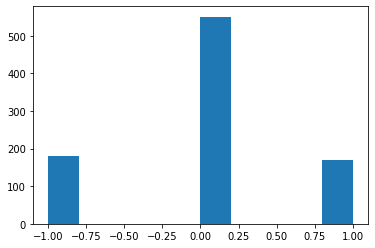

In [96]:
import matplotlib.pyplot as plt
plt.hist(yhat_unlab_LIN)

### Best RBF SVM

As we can see in the results table the best rbf model is Word2Vec (slightly worse in test than TF-IDF but better in training), the best parameters are: 
- __kernel__ :            rbf
- __C__ :                   100
- __gamma__ : 0.625

In [30]:
X_lab = []
for doc in df.BODY :
    doc = nlp(doc)
    X_lab.append(doc.vector)

X_lab = pd.DataFrame(X_lab)

In [31]:
svm_classifier = svm.SVC(class_weight='balanced', kernel='rbf', C=100, gamma=0.625)
best_rbf = svm_classifier.fit(X_lab, df.SENTIMENT) 

In [32]:
yhat_train_RBF = best_rbf.predict(X_lab)
pd.crosstab(df.SENTIMENT, yhat_train_RBF, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,All
True,,,,
-1.0,52,0,0,52
0.0,1,241,4,246
1.0,0,0,45,45
All,53,241,49,343


In [100]:
X_unlab = []
for doc in df_unlab.BODY :
    doc = nlp(doc)
    X_unlab.append(doc.vector)
    
X_unlab = pd.DataFrame(X_unlab)

In [101]:
df_unlab = data.loc[pd.isna(data.SENTIMENT)]

In [102]:
yhat_unlab_RBF = best_rbf.predict(X_unlab)

(array([101.,   0.,   0.,   0.,   0., 758.,   0.,   0.,   0.,  42.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

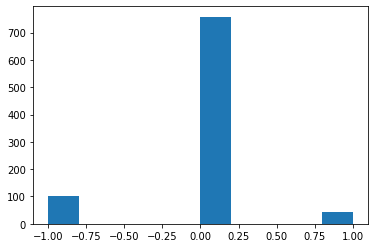

In [103]:
plt.hist(yhat_unlab_RBF)

###  Saving the predictions

- Linear Model

In [104]:
df.at[:,'SENTIMENT'] = yhat_train_LIN
df_unlab.at[:,'SENTIMENT'] = yhat_unlab_LIN
df_unlab.head(5)

C:\Users\petro\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,ARTICLE,BODY,DATE,HEADLINE,SENTIMENT
343,EMEA Calendar of Corporate Events - Week Ahead...,\nCompanies marked * are still to be confirmed...,2013-01-31 13:39:00,EMEA Calendar of Corporate Events - Week Ahead,0.0
344,International Finance: Swiss Urge An Overhaul ...,"The commission outlined a raft of measures, in...",2010-04-23 02:00:00,International Finance: Swiss Urge An Overhaul ...,0.0
345,UPDATE: Credit Suisse Targets CHF15.3 billion ...,--Swiss National Bank had singled out Credit S...,2012-07-18 08:23:00,UPDATE: Credit Suisse Targets CHF15.3 billion ...,0.0
346,WSJ UPDATE: Credit Suisse Pads Capital With CH...,"These so-called ""CoCos""--shorthand for conting...",2011-02-14 14:26:00,WSJ UPDATE: Credit Suisse Pads Capital With CH...,0.0
347,Credit Suisse sees first quarter profit dropCr...,Credit Suisse experienced a decline in the gro...,2011-04-27 07:58:53,Credit Suisse sees first quarter profit drop,0.0


In [105]:
pred = pd.concat([df,df_unlab])

In [106]:
pred.to_json('prediction_LIN.json', orient='records')

- RBF model

In [107]:
df.at[:,'SENTIMENT'] = yhat_train_RBF
df_unlab.at[:,'SENTIMENT'] = yhat_unlab_RBF
df_unlab.head(5)

,ARTICLE,BODY,DATE,HEADLINE,SENTIMENT
343,EMEA Calendar of Corporate Events - Week Ahead...,\nCompanies marked * are still to be confirmed...,2013-01-31 13:39:00,EMEA Calendar of Corporate Events - Week Ahead,0.0
344,International Finance: Swiss Urge An Overhaul ...,"The commission outlined a raft of measures, in...",2010-04-23 02:00:00,International Finance: Swiss Urge An Overhaul ...,0.0
345,UPDATE: Credit Suisse Targets CHF15.3 billion ...,--Swiss National Bank had singled out Credit S...,2012-07-18 08:23:00,UPDATE: Credit Suisse Targets CHF15.3 billion ...,0.0
346,WSJ UPDATE: Credit Suisse Pads Capital With CH...,"These so-called ""CoCos""--shorthand for conting...",2011-02-14 14:26:00,WSJ UPDATE: Credit Suisse Pads Capital With CH...,0.0
347,Credit Suisse sees first quarter profit dropCr...,Credit Suisse experienced a decline in the gro...,2011-04-27 07:58:53,Credit Suisse sees first quarter profit drop,0.0


In [108]:
pred = pd.concat([df,df_unlab])

In [109]:
pred.to_json('prediction_RBF.json', orient='records')